<center><h1><b><span style="color:blue">Histogramming & visualisation</span></b></h1></center>

#### **Quick intro to the following packages**
- `boost-histogram`.
- `aghast`.
- `mplhep`.

&nbsp;<br><center><img src="images/logo_boost_histogram.png" alt="boost-histogram package logo" style="width: 200px;"/></center>

<center><h2><b><span style="color:green">Fast and flexible multi-dimensional histograms and profiles</span></b></h2></center>

* Python bindings for the C++14 Boost.Histogram library
* No external dependency
* Very fast and feature-rich
* Multi-dimensional histograms and profiles
* Supports weighted and unweighted data
* And much much more, see docs

<div class="alert alert-info">

<b>Acknowledgements</b>

This mini-tutorial is very largely based on material by Henry Schreiner (Princeton University), with minor modifications.
</div>

### **1. Basic 1D histogram**

In [1]:
import boost_histogram as bh

import numpy as np
import matplotlib.pyplot as plt

Let's generate some data and create a histogram:

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

h1 = bh.Histogram(bh.axis.Regular(40, -2, 10))

In [3]:
h1.fill(data1)

Histogram(Regular(40, -2, 10), storage=Double()) # Sum: 981776.0 (1000000.0 with flow)

Let's explicitly check to see how many entries are in the histogram:

In [4]:
h1.sum()

981776.0

What happened to the missing items? They are in the underflow and overflow bins ;-):

In [5]:
h1.sum(flow=True)

1000000.0

As is ROOT, overflow bins are on by default. We can turn them off, but they enable some powerful things like projections.

Make sure things visually look OK:

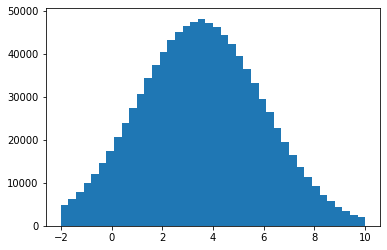

In [6]:
plt.bar(h1.axes[0].centers, h1, width=h1.axes[0].widths);

From now on, let's be lazy

In [7]:
plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths);

### **2. Drop-in replacement for NumPy**

In [8]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10)

### **3. "Extra dimensions"**
The same API works for multiple dimensions.

In [9]:
h2 = bh.Histogram(
    bh.axis.Regular(150, -1.5, 1.5),
    bh.axis.Regular(100, -1, 1)
)

h2

Histogram(
  Regular(150, -1.5, 1.5),
  Regular(100, -1, 1),
  storage=Double())

In [10]:
def make_2D_data(*, mean=(0,0), widths=(1,1), size=1_000_000):
    cov = np.asarray(widths) * np.eye(2)
    return np.random.multivariate_normal(mean, cov, size=size).T

In [11]:
data3x = make_2D_data(mean=[-.75, .5], widths=[.2, 0.02])
data3y = make_2D_data(mean=[.75, .5], widths=[.2, 0.02])

From here on out, I will be using `.reset()` before a `.fill()`, just to make sure each cell in the notebook can be rerun.

In [12]:
h2.reset()
h2.fill(*data3x)
h2.fill(*data3y)

Histogram(
  Regular(150, -1.5, 1.5),
  Regular(100, -1, 1),
  storage=Double()) # Sum: 1906047.0 (2000000.0 with flow)

Again, let's make plotting a little function:

In [13]:
def plothist2d(h):
    X, Y = h.axes.edges
    X, Y = np.broadcast_arrays(X, Y)

    return plt.pcolormesh(X, Y, h)

> The above code is the same as doing:
> 
> ```python
X, Y = np.meshgrid(*(a.edges for a in h.axes, indexing='ij')
```

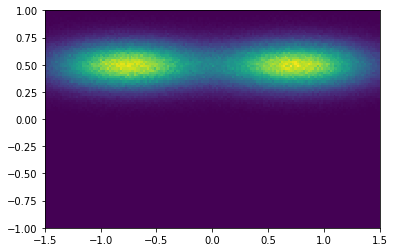

In [14]:
plothist2d(h2);

Let's try a 3D histogram

In [15]:
data3d = [np.random.normal(size=1_000_000) for _ in range(3)]

h3d = bh.Histogram(
    bh.axis.Regular(150, -5, 5),
    bh.axis.Regular(100, -5, 5),
    bh.axis.Regular(100, -5, 5)
)

h3d.fill(*data3d)

Histogram(
  Regular(150, -5, 5),
  Regular(100, -5, 5),
  Regular(100, -5, 5),
  storage=Double()) # Sum: 999999.0 (1000000.0 with flow)

Let's project to the first two axes:

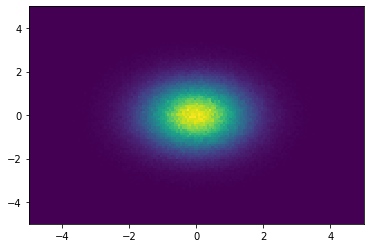

In [16]:
plothist2d(h3d.project(0,1));

### **4. Unified Histogram Indexing**

Let's explore the boost-histogram UHI syntax. We will reuse the previous 2D histogram from part 3:

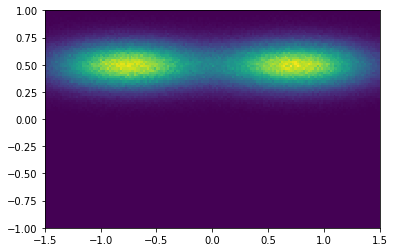

In [17]:
plothist2d(h2);

I can see that I want y from 0.25 to 0.75, in data coordinates:

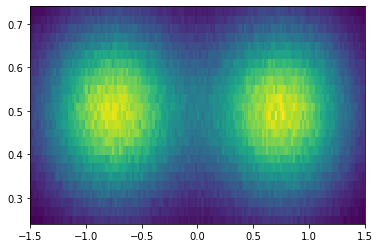

In [18]:
plothist2d(h2[:, bh.loc(.25):bh.loc(.75)]);

What's the contents of a bin?

In [19]:
h2[100,87]

177.0

How about in data coordinates?

In [20]:
h2[bh.loc(.5), bh.loc(.75)]

177.0

> Note: to get the coordinates manually:
> 
> ```python
h2.axes[0].index(.5) == 100
h2.axes[1].index(.75) == 87
```

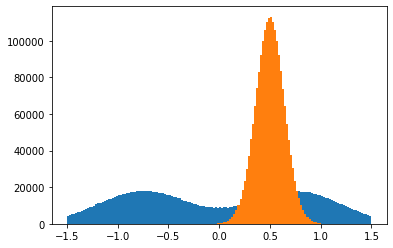

In [21]:
plothist(h2[:, ::bh.project]);
plothist(h2[::bh.project, :]);

Let's look at one part and rebin:

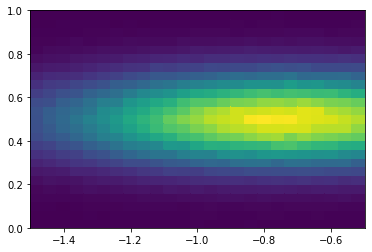

In [22]:
plothist2d(h2[:50:bh.rebin(2), 50::bh.rebin(2)]);

What is the value at `(-.75, .5)`?

In [23]:
h2[bh.loc(-.75), bh.loc(.5)]

1027.0

### **5. Fancier axis types - a circular axis example**

In [24]:
h = bh.Histogram(bh.axis.Regular(30, 0, 2*np.pi, circular=True))
h.fill(np.random.uniform(0, np.pi*4, size=300))

Histogram(Regular(30, 0, 6.28319, circular=True), storage=Double()) # Sum: 300.0

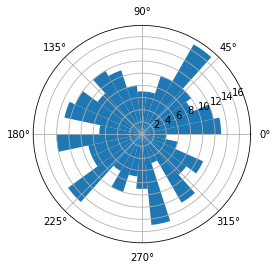

In [25]:
ax = plt.subplot(111, polar=True)

plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths)
plothist(h);

### **6. Storage and accumulators**

In [26]:
hist6 = bh.Histogram(bh.axis.Regular(10,0,10), storage=bh.storage.Mean())

In [27]:
hist6.fill([0.5]*3, sample=[.3, .4, .5])

Histogram(Regular(10, 0, 10), storage=Mean()) # Sum: Mean(count=3, value=0.4, variance=0.01)

In [28]:
hist6[0]

Mean(count=3, value=0.4, variance=0.01)

Boost-histogram has several different storages; storages store accumulators. Let's try making a profile.

In [29]:
mean = bh.accumulators.Mean()
mean.fill([.3, .4, .5])

Mean(count=3, value=0.4, variance=0.01)

Here's a quick example accessing the values:

In [30]:
print(f"mean.count={mean.count} mean.value={mean.value} mean.variance={mean.variance}")

# Python 3.8:
# print(f"{mean.count=} {mean.value=} {mean.variance=}")

mean.count=3.0 mean.value=0.39999999999999997 mean.variance=0.010000000000000005


&nbsp;<br><center><img src="images/logo_aghast.png" alt="aghast package logo" style="width: 200px;"/></center>

<center><h2><b><span style="color:green">Aggregated, histogram-like statistics, sharable as Flatbuffers</span></b></h2></center>

As the package README says:

- *Aghast is a histogramming library that does not fill histograms and does not plot them. Its role is behind the scenes, to provide better communication between histogramming libraries.*!

- *The purpose of aghast is to be an intermediate when converting ROOT histograms into NumPy, or vice-versa, or both of these into Boost.Histogram, Physt, Pandas, etc. Without an intermediate representation, converting between N libraries (to get the advantages of all) would equire N(N ‒ 1)/2 conversion routines; with an intermediate representation, we only need N, and the mapping of feature to feature can be made explicit in terms of a common language.*

**In other words, `aghast` is designed to move aggregated, histogram-like statistics (called "ghasts") from one framework to the next.**

A very brief intro follows below. See the [GitHub repository](https://github.com/scikit-hep/aghast) for full documentation and a more comprehensive tutorial. 

In [31]:
import aghast

import numpy

In [32]:
h_numpy = numpy.histogram(numpy.random.normal(0, 1, 100000), bins=20, range=(-5, 5))
h_numpy

(array([    0,     3,    17,   131,   469,  1663,  4369,  9236, 14763,
        19095, 19090, 15172,  9288,  4369,  1651,   534,   129,    20,
            1,     0]),
 array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]))

Conversion are done via `from_XXX` and `to_XXX`connections. Let's get the "aghast equivalent":

In [33]:
h_aghast = aghast.from_numpy(h_numpy)

h_aghast.dump()

Histogram(
  axis=[
    Axis(binning=RegularBinning(num=20, interval=RealInterval(low=-5.0, high=5.0)))
  ],
  counts=
    UnweightedCounts(
      counts=
        InterpretedInlineInt64Buffer(
          buffer=
              [    0     3    17   131   469  1663  4369  9236 14763 19095 19090 15172
                9288  4369  1651   534   129    20     1     0])))


In [34]:
h_pandas = aghast.to_pandas(h_aghast)

h_pandas

,unweighted
"[-5.0, -4.5)",0
"[-4.5, -4.0)",3
"[-4.0, -3.5)",17
"[-3.5, -3.0)",131
"[-3.0, -2.5)",469
"[-2.5, -2.0)",1663
"[-2.0, -1.5)",4369
"[-1.5, -1.0)",9236
"[-1.0, -0.5)",14763
"[-0.5, 0.0)",19095


**Interoperability with ROOT** uses yet another connector:

Welcome to JupyROOT 6.20/00


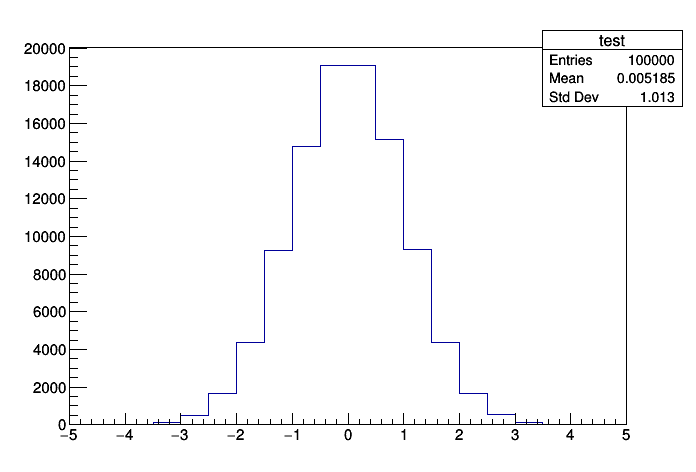

In [35]:
h_root = aghast.to_root(h_aghast,name='test')

import ROOT

c = ROOT.TCanvas()
h_root.Draw()
c.Draw()

Serialization of the "ghast"  produces a *Flatbuffers* object, which has a random-access and small footprint:

In [36]:
print("Numpy size: ", h_numpy[0].nbytes + h_numpy[1].nbytes)

tmessage = ROOT.TMessage()
tmessage.WriteObject(h_root)
print("ROOT size:  ", tmessage.Length())

import pickle
print("Pandas size:", len(pickle.dumps(h_pandas)))

print("Aghast size: ", len(h_aghast.tobuffer()))

Numpy size:  328
ROOT size:   1471
Pandas size: 1550
Aghast size:  312


&nbsp;<br><center><img src="images/logo_mplhep.png" alt="mplhep package logo" style="width: 200px;"/></center>

<center><h2><b><span style="color:green">HEP domain-specific add-ons to matplotlib</span></b></h2></center>

In [37]:
import mplhep

import numpy as np
import matplotlib.pyplot as plt

### **1. Some basics**

"Standard" 1D histograms:

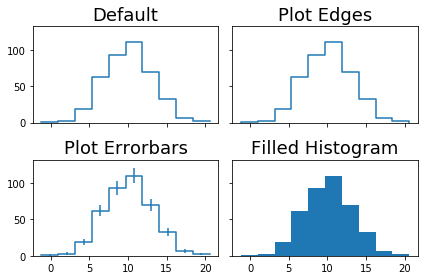

In [38]:
h, bins = np.histogram(np.random.normal(10,3,400), bins = 10)

f, axs = plt.subplots(2,2, sharex=True, sharey=True)
axs = axs.flatten()

axs[0].set_title("Default", fontsize=18)
mplhep.histplot(h, bins, ax=axs[0])

axs[1].set_title("Plot Edges", fontsize=18)
mplhep.histplot(h, bins, edges=True, ax=axs[1])

axs[2].set_title("Plot Errorbars", fontsize=18)
mplhep.histplot(h, bins, yerr=np.sqrt(h), ax=axs[2])

axs[3].set_title("Filled Histogram", fontsize=18)
mplhep.histplot(h, bins, histtype='fill', ax=axs[3])


plt.tight_layout()
plt.show()

1D histograms with overlay:

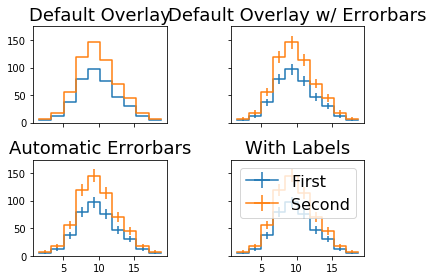

In [39]:
h, bins = np.histogram(np.random.normal(10,3,400), bins = 10)

f, axs = plt.subplots(2,2, sharex=True, sharey=True)
axs = axs.flatten()

axs[0].set_title("Default Overlay", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, ax=axs[0])

axs[1].set_title("Default Overlay w/ Errorbars", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, yerr=[np.sqrt(h), np.sqrt(1.5*h)], ax=axs[1])


axs[2].set_title("Automatic Errorbars", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, yerr=True, ax=axs[2])

axs[3].set_title("With Labels", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, yerr=True, ax=axs[3], label=["First", "Second"])

axs[3].legend(fontsize=16)

plt.tight_layout()
plt.show()

Stacked 1D histogram:

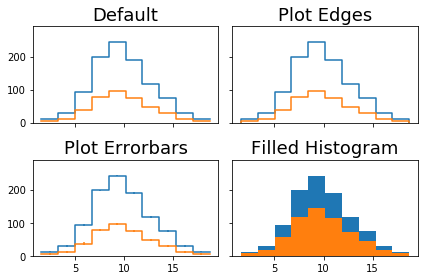

In [40]:
f, axs = plt.subplots(2,2, sharex=True, sharey=True)#, figsize=(10, 5))
axs = axs.flatten()

axs[0].set_title("Default", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, stack=True, ax=axs[0])

axs[1].set_title("Plot Edges", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, edges=True, stack=True,ax=axs[1])

axs[2].set_title("Plot Errorbars", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, yerr=np.sqrt(h), stack=True, ax=axs[2])

axs[3].set_title("Filled Histogram", fontsize=18)
mplhep.histplot([1.5*h, h], bins, histtype='fill', stack=True, ax=axs[3])

plt.tight_layout()
plt.show()

### **2. Fancier plots**

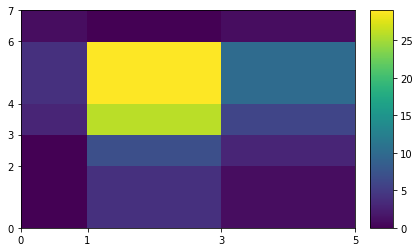

In [41]:
fig, ax = plt.subplots()

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6,7]
x = np.random.normal(2, 1, 100)
y = np.random.normal(4, 1, 100)

mplhep.hist2dplot(*np.histogram2d(x, y, bins=(xedges, yedges)));

Starting from a `boost-histogram` histogram? Just do the following:

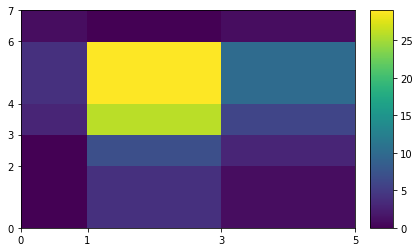

In [42]:
h2 = bh.Histogram(
    bh.axis.Variable(xedges),
    bh.axis.Variable(yedges)
)
h2.fill(x,y)

mplhep.hist2dplot(*h2.to_numpy());

### **3. Styling**

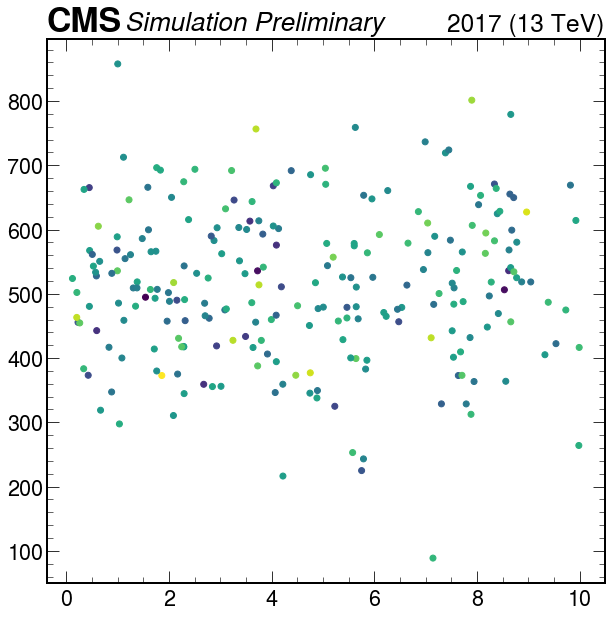

In [43]:
x = np.random.uniform(0, 10, 240)
y = np.random.normal(512, 112, 240)
z = np.random.normal(0.5, 0.1, 240)

plt.style.use([mplhep.style.ROOT, mplhep.style.firamath])

f, ax = plt.subplots()
ax.scatter(x,y, c=z, label='XSX')
mplhep.cms.cmslabel(loc=0)

plt.show()

A more complicated example:

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


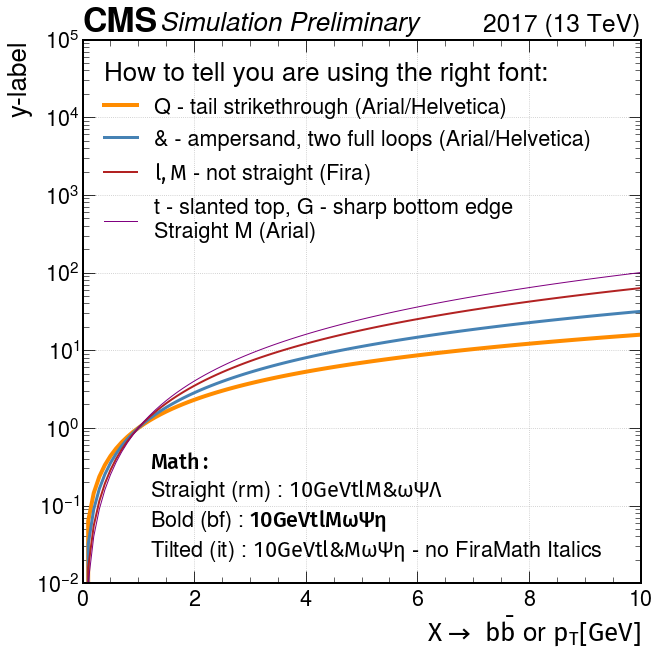

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
C = ['darkorange', 'steelblue', 'firebrick', 'purple']

# Figure
f, ax = plt.subplots()

# Make some data
x = np.linspace(0,10,101)
y0 = x**(1.2)
y1 = x**(1.5)
y2 = x**(1.8)
y3 = x**(2)

ax.plot(x, y0, lw=4, label=r"Q - tail strikethrough (Arial/Helvetica) ", c=C[0])
ax.plot(x, y1, lw=3, label=r"& - ampersand, two full loops (Arial/Helvetica)", c=C[1])
ax.plot(x, y2, lw=2, label=r"$\mathrm{l, M}$ - not straight (Fira)", c=C[2])
ax.plot(x, y3, lw=1, label=r"t - slanted top, G - sharp bottom edge" "\n" r"Straight M (Arial)", c=C[3])

# Set limits and labels
ax.set_xlim(0,10)
ax.set_ylim(0.01,100000)
ax.set_xlabel(r'$\mathrm{X \rightarrow\ b\bar{b}}$ or $\mathrm{p_T [GeV]}$', ha='right', x=1.0)
ax.set_ylabel('y-label', ha='right', y=1.0)

# Legend
leg = ax.legend(borderpad=0.5, frameon=False, loc=2)
leg.set_title('How to tell you are using the right font:')
leg._legend_box.align = "left" # Align legend title

# Annotationg and math examples
math_desc =  r"$\mathbf{Math:}$" \
      + "\n" +r"Straight (rm) : $\mathrm{10GeVtlM&\omega\Psi\Lambda}$" \
      + "\n" +r"Bold (bf) : $\mathbf{10GeVtlM\omega\Psi\eta}$" \
      + "\n" +r"Tilted (it) : $\mathit{10GeVtl&M\omega\Psi\eta}$ - no FiraMath Italics" 
ax.annotate(math_desc, xy=(0.12, 0.05), xycoords='axes fraction', fontsize = "small",
             ha='left', annotation_clip=False)

# Apply CMS labels and ticks
#ax = cms_annot(ax, data=True, lumi=2.5)
mplhep.cms.cmslabel()

ax.grid()
ax.semilogy()

ax;